# Modules

In [1]:
import pandas as pd
import numpy as np
import csv
import time
import os

from textblob import TextBlob
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

## TextBlob Sentiment Analysis

In [2]:
try:
    df = pd.read_csv('/workspaces/Project-Uchumi/data/processed/preprocessed_articles.csv')
except FileNotFoundError:
    df = pd.DataFrame(columns=['url', 'article', 'date'])

# Function to analyze sentiment
def analyze_sentiment(cleaned_article):
    text = cleaned_article
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply sentiment analysis to each article
df['polarity'], df['subjectivity'] = zip(*df['cleaned_article'].apply(analyze_sentiment))

# Display the results
print(df[['article', 'cleaned_article', 'polarity', 'subjectivity']])

                                              article  \
0   A disagreement between two widows in Kakamega ...   
1   Meru County government is yet to pass its 2024...   
2   What you need to know:\n- At least 23 youths w...   
3   What you need to know:\n- Residents feel autho...   
4   What you need to know:\n- Dish out money and g...   
5   Hi Pastor,\nMy step dad married my biological ...   
6   What you need to know:\n- Gen Zs' gamophobia —...   
7   What you need to know:\n- Irrespective of octa...   
8   What you need to know:\n- Self-care is wholeso...   
9   Somali President Hassan Sheikh Mohamud came to...   
10  The recent Kenyan protests are a warning that ...   
11  Trapped in a Catholic mission sheltering dozen...   
12  What you need to know:\n- In Nairobi on Tuesda...   
13  What you need to know:\n- Learning resumed on ...   
14  What you need to know:\n- Despite the normalis...   
15  What you need to know:\n- I had my first ever ...   
16  What you need to know:\n- B

In [ ]:
df

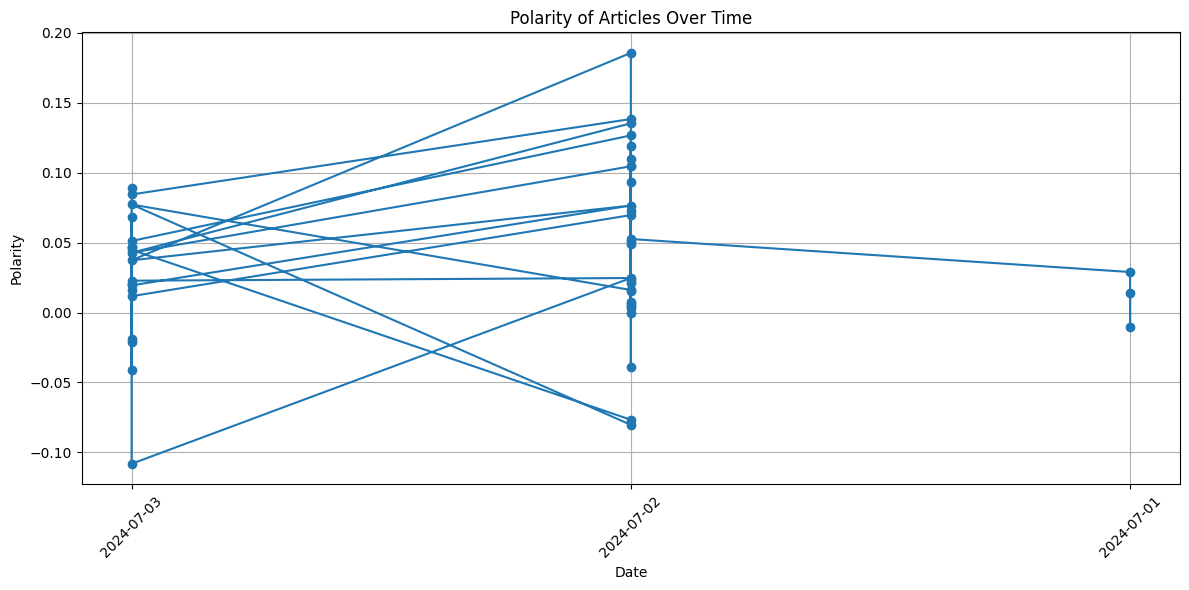

In [3]:
# Assuming 'date' is a column in the DataFrame
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['polarity'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Polarity')
plt.title('Polarity of Articles Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# Keyword Extraction

In [ ]:
# Sample data
data = [
    "This is a sample document.",
    "Another example of a document.",
    "And another one for good measure."
]

# Create the TF-IDF vectorizer
tfidf = TfidfVectorizer()

# Fit the vectorizer and transform the data
tfidf_matrix = tfidf.fit_transform(data)

# Get the feature names (words)
feature_names = tfidf.get_feature_names_out()

# Find the most important word in each document
for i in range(len(data)):
    doc = tfidf_matrix[i]
    word_idx = doc.indices[doc.data.argmax()]
    keyword = feature_names[word_idx]
    print(f"Keyword in document {i+1}: {keyword}")


In [ ]:
# Sample data
data = df['cleaned_article'].tolist()

# Create the TF-IDF vectorizer
tfidf = TfidfVectorizer()

# Fit the vectorizer and transform the data
tfidf_matrix = tfidf.fit_transform(data)

# Get the feature names (words)
feature_names = tfidf.get_feature_names_out()
print(feature_names)

# Find the most important word in each document
keywords = []
for i in range(len(data)):
    doc = tfidf_matrix[i]
    word_idx = doc.indices[doc.data.argmax()]
    keyword = feature_names[word_idx]
    keywords.append(keyword)

# Add the keywords to the dataframe
df['keywords'] = keywords

# Print the keywords for each article
print(df[['cleaned_article', 'keywords']])

# Topic Modelling

In [ ]:
from gensim import corpora, models
import gensim

# Sample data
data = df['cleaned_article'].tolist()

# Tokenize the data
tokenized_data = [article.split() for article in data]
print(f"tokenized data : {tokenized_data}")

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(tokenized_data)
print(f"Dictionary : {dictionary}")

# Filter out words that occur less than 20 documents, or more than 50% of the documents
dictionary.filter_extremes(no_below=3, no_above=0.8)
print(f"Filtered dictionary : {dictionary}")

# Convert the documents into a bag-of-words corpus
corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_data]
print(f"Dictionary.doc2bow([0]): {dictionary.doc2bow(tokenized_data[0])}")
print(f"Corpus : {corpus}")

# Train the LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                             id2word=dictionary,
                                             num_topics=5,
                                             random_state=42,
                                             update_every=1,
                                             chunksize=100,
                                             passes=10,
                                             alpha='auto',
                                             per_word_topics=True)

# Print the topics
print(len(lda_model.print_topics(-1)))
for idx, topic in lda_model.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}\n')

# Assign the topics to the documents
# Extract topics from the LDA model
topic_results = lda_model[corpus]

# Extract the dominant topic for each article
print("Topic 1", topic_results[0][0], max(topic_results[0][0],key=lambda x: x[1]))
print("Topic 2", topic_results[1][0], max(topic_results[1][0],key=lambda x: x[1]))
print("Topic 3", topic_results[2][0], max(topic_results[2][0],key=lambda x: x[1]))
print("Topic 4", topic_results[3][0], max(topic_results[3][0],key=lambda x: x[1]))
print("Topic 5", topic_results[4][0], max(topic_results[4][0],key=lambda x: x[1]))
print([max(topic[0],key=lambda x: x[1]) for topic in topic_results])
dominant_topics = [max(topic[0],key=lambda x: x[1]) for topic in topic_results]

# Add the dominant topics to the dataframe
df['dominant_topic'] = [dictionary.id2token[topic[0]] for topic in dominant_topics]
df['topic_probability'] = [topic[1] for topic in dominant_topics]

# Print the dominant topic and its probability for each article
for index, row in df.iterrows():
    print(f"Article {index + 1} - Dominant Topic: {row['dominant_topic']}, Probability: {row['topic_probability']}")


# Export Analyzed Data

In [ ]:
df.to_csv("/workspaces/Project-Uchumi/data/processed/analyzed_articles.csv", index=False, mode='a', header=not os.path.exists("/workspaces/Project-Uchumi/data/processed/analyzed_articles.csv"))